# <center> Module 6

Group: 12<br>
Darko Petrov<br>
Alexander Lendon

<!---# Q1

The purpose of this assignment is to compare SGD, SAG and SAGA for a binary classification task by logistic regression. Remember that the logistic loss function is given by

$$
\ell(\theta, \mu, x_i, y_i) = \log(1 + \exp(-y_i (\theta^T x_i + \mu))) 
$$

where $x_i$, $\R^m$ and $y_i ∈ {−1, 1}$ are a data sample and its corresponding label. Logistic regression is performed by solving

$$
\min_{\theta, \mu} \frac{1}{n} \sum^n_{i=0} \ell(\theta, \mu, x_i, y_i) + \frac{\lambda}{2} \|\theta\|^2
$$



1. Show that the proximal operator of $R(θ) = \frac{\lambda}{2} \|\theta\|^2$ is given by 

$$
prox_{\mu R}(\theta) = \frac{\theta}{1 + \mu \lambda}\theta
$$

<!---2. Write python functions that implement SGD, SAG and SAGA with a fixed step size. For SGD and SAG, write the objective function of
(2) as a finite sum $\frac{1}{n} \sum f_i(\theta, \mu)$ where $f_i(\theta, \mu) = \ell(\theta, \mu, x_i, y_i) + \frac{\lambda}{2} \|\theta\|^2$. For SAGA, use the composite form $\frac{1}{n} \sum^n_{i=0} f_i + R$ where $f_i(\theta, \mu) = \ell(\theta, \mu, x_i, y_i)$ and $R = \frac{\lambda}{2} \|\theta\|^2$.


<!---3. Apply the three algorithms to the ”Australian” dataset, which includes the credit decisions based on 14 anonymized features. Use fixed step sizes and set 0 the missing values. Run each algorithm for 100 epochs. Write a report with the following

(a) plots showing the objective value over different iterations for the three
algorithms.

(b) Try different step sizes and discuss its effect especially for the SGD.

(c) Discuss the memory requirement of each algorithm

## Q1.

#### 1)
The proximal operator of a function $R(\theta)$ is defined as:

$$\text{prox}_{\mu R}(\theta) = \arg\min_{z} \left\{ R(z) + \frac{1}{2\mu}\|z - \theta\|^2 \right\}$$

In this case, $R(\theta) = \frac{\lambda}{2} \|\theta\|^2_2$, which is the L2 regularization term. 

Minimize the function $L(z)$ with respect to $z$:
$$
L(z) = R(z) + \frac{1}{2\mu}\|z - \theta\|^2 \\
= \frac{\lambda}{2} \|z\|^2_2 + \frac{1}{2\mu}\|z - \theta\|^2
$$

Taking the derivative of $L(z)$ with respect to $z$ and setting it to zero gives:

$$\lambda z + \frac{1}{\mu}(z - \theta) = 0$$

Solving for $z$ gives the argument for minimum solution:

$$
z = \frac{1}{1 + \mu\lambda}\theta
$$

So, the proximal operator of $R(\theta) = \frac{\lambda}{2} \|\theta\|^2_2$ is given by:

$$\text{prox}_{\mu R}(\theta) = \frac{1}{1 + \mu\lambda}\theta$$

In [9]:
import numpy as np

def theta_grad(theta, mu, xi, yi, lambd):
    return -(yi*xi)/(1+np.exp(yi*(np.dot(theta.T,xi)+mu))) + lambd*theta
def theta_grad_saga(theta, mu, xi, yi, lambd):
    return -(yi*xi)/(1+np.exp(yi*(np.dot(theta.T,xi)+mu)))
def mu_grad(theta, mu, xi, yi):
    return -(yi)/(1+np.exp(yi*(np.dot(theta.T,xi)+mu)))
def objective_value_function(theta, mu, xi, yi, lambd):
    return np.log(1+np.exp(-yi *(np.dot(xi, theta.T)+mu))) + (lambd/2)*np.linalg.norm(theta)**2

def SGD(theta, mu, x, y, lambd, step_size, max_iter):
    obj_val = []
    for _ in range(max_iter):
        i = np.random.randint(0, len(y))
        grad_theta = theta_grad(theta, mu, x[i], y[i], lambd)
        grad_mu = mu_grad(theta, mu, x[i], y[i])
        theta = theta - step_size*grad_theta
        mu = mu - step_size*grad_mu
        obj_val.append(objective_value_function(theta, mu, x[i], y[i], lambd))
    return theta, mu, np.sum(obj_val)/max_iter

def SAG(theta, mu, x, y, lambd, step_size, max_iter):
    theta_his = [theta]
    mu_his = [mu]
    obj_val = []
    for _ in range(max_iter):
        i = np.random.randint(0, len(y))
        theta_his.append(theta_grad(theta, mu, x[i], y[i], lambd))
        mu_his.append(mu_grad(theta, mu, x[i], y[i]))
        theta -= step_size * (np.mean(theta_his, axis=0))
        mu -= step_size * (np.mean(mu_his))
        obj_val.append(objective_value_function(theta, mu, x[i], y[i], lambd))
    return theta, mu, np.sum(obj_val)/max_iter


def SAGA(theta, mu, x, y, lambd, step_size, max_iter):
    theta_his = [theta]
    mu_his = [mu]
    obj_val = []
    for _ in range(max_iter):
        i = np.random.randint(0, len(y))
        theta_his.append(theta_grad_saga(theta, mu, x[i], y[i], lambd))
        mu_his.append(mu_grad(theta, mu, x[i], y[i]))
        theta = theta - step_size * (theta_his[-1] - theta_his[-2] + np.mean(theta_his, axis=0))
        theta = theta/(1+(mu*lambd))
        mu = mu - step_size * (mu_his[-1] - mu_his[-2] + np.mean(mu_his))
        obj_val.append(objective_value_function(theta, mu, x[i], y[i], lambd))
        
    return theta, mu, np.sum(obj_val)/max_iter


In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
import tqdm.notebook as tq
import numpy as np
np.random.seed(0)

# Load the Australian dataset
x, y = load_svmlight_file('australian_scale.txt')
x = x.toarray()

# Set the step size and the number of epochs
step_sizes = [1e-2, 1e-3, 1e-4, 1e-5]
lambd = 1e-5
max_iter = int(len(y)*10)
# max_iter = 1000
num_epochs = 100




  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

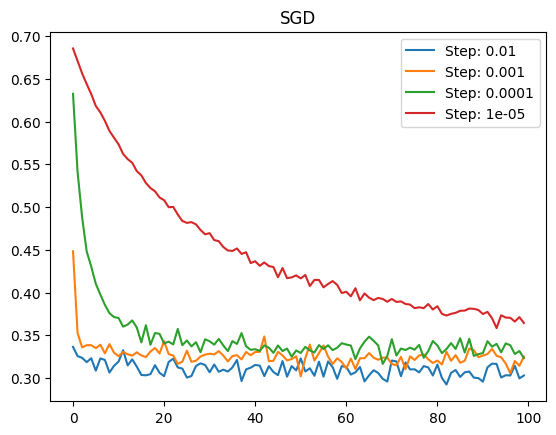

In [11]:
for step_size in step_sizes:
    theta_sgd = np.zeros(x.shape[1])
    mu_sgd = 0

    objective_values_sgd_lis = []
    for epoch in tq.tqdm(range(num_epochs))
        theta_sgd, mu_sgd, obj_val_sgd = SGD(theta_sgd, mu_sgd, x, y, lambd, step_size, max_iter)
        objective_values_sgd_lis.append(obj_val_sgd)
        
    plt.plot(objective_values_sgd_lis, label=f'Step: {step_size}')
plt.legend()
plt.title('SGD')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

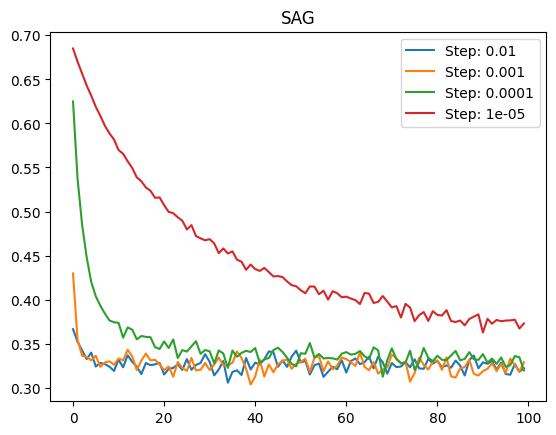

In [12]:
for step_size in step_sizes: 
    theta_sag = np.zeros(x.shape[1])
    mu_sag = 0

    objective_values_sag_lis = []
    for epoch in tq.tqdm(range(num_epochs)):
        theta_sag, mu_sag, obj_val_sag = SAG(theta_sag, mu_sag, x, y, lambd, step_size, max_iter)
        objective_values_sag_lis.append(obj_val_sag)
        
    plt.plot(objective_values_sag_lis, label=f'Step: {step_size}')
plt.legend()
plt.title('SAG')
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

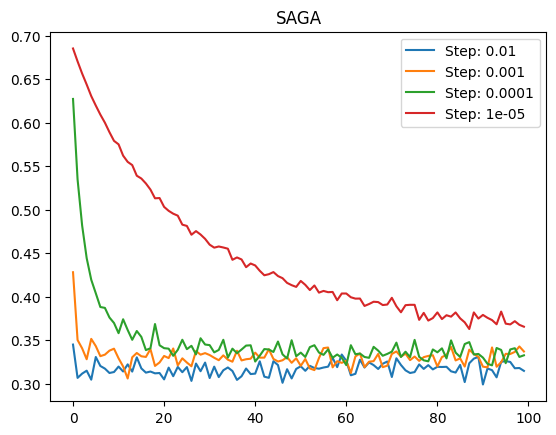

In [13]:
for step_size in step_sizes:
    theta_saga = np.zeros(x.shape[1])
    mu_saga = 0
    objective_values_saga_lis = []
    for epoch in tq.tqdm(range(num_epochs)):
        theta_saga, mu_saga, obj_val_saga = SAGA(theta_saga, mu_saga, x, y, lambd, step_size, max_iter)
        objective_values_saga_lis.append(obj_val_saga)
        
    plt.plot(objective_values_saga_lis, label=f'Step: {step_size}')
plt.legend()
plt.title('SAGA')
plt.show()

#### (b) 

The step size affects the convergence of the algorithm. Another thing from the step size is that it affects the noise produced from the algorithm's randomness. In the plots above it was run for 10 times the length of the data and this reduces the noise bur when run for fewer iterations it can be seen that the noise is more significant and bigger step sizes amplify the noise. 

#### (c)

For the SGD algorithm in the purpose of the assignment we only store the objective value and the memory required is only equal to the number of iterations the algorithm is run for. For the other two algorithms we need to store the gradients the theta and mu variables and the memory for each iteration is increasing. This also affects the speed of the algorithms as for each iteration we need to calculate the mean of all previously stored gradients. In attempt to reduce the noise the algorithms need to be run for more iterations than the length of the data. This means that the memory required for the SAG and SAGA increases much more than the SGD algorithm.

## Q2.
#### 1)
The update rule for $\hat{x}_t(\omega)$:

$$\hat{x}_t(\omega) = x_t - \mu_t \nabla f(x_t, \omega)$$

As we are looking  for the squared difference between updates, subtract $x_t$ from both sides and square the result:

$$(\hat{x}_t(\omega) - x_t)^2 = \mu_t^2 (\nabla f(x_t, \omega))^2$$

Now, take the expectation over $\omega$ on both sides:

$$E_{\omega}[(\hat{x}_t(\omega) - x_t)^2] = E_{\omega}[\mu_t^2 (\nabla f(x_t, \omega))^2]$$

Using properties of variance and expectation $\text{Var}(X) = E[X^2]-(E[X])^2$ which in our case can be used to express the following:
$$
    E_{\omega}[\nabla f(x_t, \omega)^2] = \mu_t^2(\textit{Var}(\nabla f(x_t, \omega))+(E_{\omega}[\nabla f(x_t)])^2)
$$
And simplifying the expected value by $ E_\omega[\nabla f(x_t, \omega)]=\nabla f(x_t) $:
$$
    E_{\omega}[\nabla f(x_t, \omega)^2] = \mu_t^2(\textit{Var}(\nabla f(x_t, \omega))+(\nabla f(x_t))^2)
$$
As the variance of the gradient is less than some constant $c$ $\textit{Var}(\nabla F(x_t)) \leq c$:

$$
\mu_t^2(\textit{Var}(\nabla f(x_t, \omega))+\nabla (f(x_t))^2) \leq \mu_t^2 ((\nabla F(x_t))^2 + c)
$$

So, we have the desired inequality:

$$E_{\omega}[(\hat{x}_t(\omega) - x_t)^2] \leq \mu_t^2 ((\nabla F(x_t))^2 + c)$$

#### 2)
Starting with the $L$-smoothness inequality (8):

$$F(\hat{x}_t(\omega)) \leq F(x_t) + \nabla F(x_t) \times (\hat{x}_t(\omega) - x_t) + \frac{L}{2} (\hat{x}_t(\omega) - x_t)^2$$

Substitute the definition of $\hat{x}_t(\omega)$:

$$F(x_t - \mu_t \nabla f(x_t, \omega)) \leq F(x_t) - \mu_t \nabla F(x_t) \nabla f(x_t, \omega) + \frac{L \mu_t^2}{2} (\nabla f(x_t, \omega))^2$$

Rearrange terms and take expectation over $\omega$:

$$E_{\omega}[F(x_t) - F(\hat{x}_t(\omega))] \leq \mu_t E_{\omega}[\nabla F(x_t) \nabla f(x_t, \omega)] - \frac{L \mu_t^2}{2} E_{\omega}[(\nabla f(x_t, \omega))^2]$$

Using the fact that $E_{\omega}[\nabla f(x_t, \omega)] = \nabla F(x_t)$ and the result from part 1, we get:

$$E_{\omega}[F(x_t) - F(\hat{x}_t(\omega))] \leq \mu_t (\nabla F(x_t))^2 - \frac{L \mu_t^2}{2} (\mu_t^2 ((\nabla F(x_t))^2 + c))$$

Using (7) and flipping the inequality we can substitute in these expressions including $(\nabla F(x_t))^2$:
$$
-E_{\omega}[(\hat{x}_t(\omega) - x_t)^2] \geq -\mu_t^2 ((\nabla F(x_t))^2 + c)
$$
$$
c -\frac{1}{\mu_t^2}E_{\omega}[(\hat{x}_t(\omega) - x_t)^2] \geq - ((\nabla F(x_t))^2)
$$
Resulting in the following:
$$
E_{\omega}[F(x_t) - F(\hat{x}_t(\omega))] \leq 
-\mu_t (c -\frac{1}{\mu_t^2}E_{\omega}[(\hat{x}_t(\omega) - x_t)^2]) - 
\frac{L \mu_t^2}{2} (E_{\omega}[(\hat{x}_t(\omega) - x_t)^2])
$$
Rearranging for $E_{\omega}[(\hat{x}_t(\omega) - x_t)^2]$:
$$
E_{\omega}[F(x_t) - F(\hat{x}_t(\omega))] \leq 
E_{\omega}[(\hat{x}_t(\omega) - x_t)^2](\frac{1}{\mu_t} - \frac{L \mu_t^2}{2})
-\mu_t c
$$
Rearranging again and flip the inequality by multiplying by -1
$$
E_{\omega}[(\hat{x}_t(\omega) - x_t)^2] \leq \frac{1}{(\frac{1}{\mu_t} - \frac{L \mu_t^2}{2})}  (\mu_t c - E_{\omega}[F(x_t) - F(\hat{x}_t(\omega))])
$$
Multiply both sides by $\frac{1}{2}$ take factors of $\frac{1}{\mu_t}$ out of the fraction on the right:
$$
E_{\omega}[(\hat{x}_t(\omega) - x_t)^2] \leq \frac{1}{(2 - L \mu_t)}  (\mu_t^2 c - \mu_t E_{\omega}[F(x_t) - F(\hat{x}_t(\omega))])
$$

#### 3)
Given the convexity of $F$, we have:

$$F(x^*) \geq F(x_t) + \nabla F(x_t)(x^* - x_t) \tag{10}$$

Rearranging terms, we get:

$$F(x_t) - F(x^*) \leq \nabla F(x_t)(x_t - x^*)$$

Multiplying both sides by $\mu_t$, we get:

$$\mu_t (F(x_t) - F(x^*)) \leq \mu_t \nabla F(x_t)(x_t - x^*)$$

Looking at the term $\frac{1}{2}E_\omega[(\hat{x}_t(\omega) - x^*)^2 - (\hat{x}_t(\omega) - x_t)^2]$. By the definition of conditional expectation, we can write this as:

$$\frac{1}{2}E_\omega[(\hat{x}_t(\omega) - x^*)^2 - (\hat{x}_t(\omega) - x_t)^2] = \frac{1}{2}[(\hat{x}_t - x^*)^2 - (\hat{x}_t  - x_t)^2]$$

Adding this to the inequality we derived earlier, we get:

$$\mu_t (F(x_t) - F(x^*)) + \frac{1}{2}E_\omega[(\hat{x}_t(\omega) - x^*)^2 - (\hat{x}_t(\omega) - x_t)^2] \leq \mu_t \nabla F(x_t)(x_t - x^*) + \frac{1}{2}[(\hat{x}_t - x^*)^2 - (\hat{x}_t  - x_t)^2]$$

Splitting the expectation and rearranging
$$\mu_t (F(x_t) - F(x^*)) + \frac{1}{2}E_\omega[(\hat{x}_t(\omega) - x^*)^2] \leq  \frac{1}{2}E_\omega[(\hat{x}_t(\omega) - x_t)^2] + \mu_t \nabla F(x_t)(x_t - x^*) + \frac{1}{2}[(\hat{x}_t - x^*)^2 - (\hat{x}_t  - x_t)^2]$$

Looking at the term $(\hat{x}_t - x^*)^2 - (\hat{x}_t  - x_t)^2 $ and expanding we can express it as:
$$
(\hat{x}_t - x^*)^2 - (\hat{x}_t  - x_t)^2 = \hat{x}_t(\omega)^2-\hat{x}_t(\omega)^2 + x^{*2} - x_t^2 +2\hat{x}_t(\omega)(x_t-x^*)
$$
Substituting $\hat{x}_t(\omega) = x_t - \mu_t \nabla f(x_t, \omega)$ and expanding for x_t
$$
x^{*2} - x_t^2 +2(x_t - \mu_t \nabla f(x_t, \omega))(x_t-x^*) \\
= x^{*2} - x_t^2 +2x_t^2 - 2x_tx^* - 2\mu_t \nabla f(x_t, \omega)(x_t-x^*) \\
= x^{*2} - 2x_tx^* + x_t^2 - 2\mu_t \nabla f(x_t, \omega)(x_t-x^*)
$$
gives:
$$
(\hat{x}_t - x^*)^2 - (\hat{x}_t  - x_t)^2 = (x_t  - x^{*})^2 - 2\mu_t \nabla f(x_t, \omega)(x_t-x^*)
$$
Substituting into the inequality:
$$\mu_t (F(x_t) - F(x^*)) + \frac{1}{2}E_\omega[(\hat{x}_t(\omega) - x^*)^2] \leq  \frac{1}{2}E_\omega[(\hat{x}_t(\omega) - x_t)^2] + \mu_t \nabla F(x_t)(x_t - x^*) + \frac{1}{2}[(x_t  - x^{*})^2 - 2\mu_t \nabla f(x_t, \omega)(x_t-x^*)]$$
Rearranging and simplifying:
$$\mu_t (F(x_t) - F(x^*)) + \frac{1}{2}E_\omega[(\hat{x}_t(\omega) - x^*)^2 - (x_t  - x^{*})^2] \leq  \frac{1}{2}E_\omega[(\hat{x}_t(\omega) - x_t)^2] + \mu_t \nabla F(x_t)(x_t - x^*) -\mu_t \nabla f(x_t, \omega)(x_t-x^*)$$

Using $E_{\omega}[\nabla f(x_t, \omega)] = \nabla F(x_t)$:
$$
\mu_t E_{\omega}[\nabla f(x_t, \omega)](x_t - x^*) -\mu_t \nabla f(x_t, \omega)(x_t-x^*)
$$
The desired inequality:
$$\mu_t (F(x_t) - F(x^*)) + \frac{1}{2}(E_\omega[(\hat{x}_t(\omega) - x^*)^2] - (x_t - x^*)^2) \leq  \frac{1}{2}E_\omega[(\hat{x}_t(\omega) - x_t)^2]$$